# **Assignment 7**
## **Group 3:**
* Karyl Grasparil
* Mariah Quinquito
* Yanna Polonia

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, Dropout, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

# 1. Data

## Loading train and test images / labels into pandas dataframes and converting them to numpy arrays

In [20]:
# Load train and test data (images and labels)
train_images = pd.read_csv('csvTrainImages 60k x 784.csv')  
train_labels = pd.read_csv('csvTrainLabel 60k x 1.csv')    
test_images = pd.read_csv('csvTestImages 10k x 784.csv')   
test_labels = pd.read_csv('csvTestLabel 10k x 1.csv')      

# Convert dataframes to numpy arrays
train_images_array = train_images.values
train_labels_array = train_labels.values
test_images_array = test_images.values
test_labels_array = test_labels.values

In [21]:
# Print the shape of each array
print(f"Shape of train images: {train_images_array.shape}")
print(f"Shape of train labels: {train_labels_array.shape}")
print(f"Shape of test images: {test_images_array.shape}")
print(f"Shape of test labels: {test_labels_array.shape}")

Shape of train images: (59999, 784)
Shape of train labels: (59999, 1)
Shape of test images: (9999, 784)
Shape of test labels: (9999, 1)


## Normalizing data by dividing each value by 255 and reshaping arrays so each image is 28 X 28

In [ ]:
# Normalize the image data
train_images_normalized = train_images_array / 255.0
test_images_normalized = test_images_array / 255.0

# Reshape to 28x28 grayscale images
train_images = train_images_normalized.reshape(-1, 28, 28, 1)
test_images = test_images_normalized.reshape(-1, 28, 28, 1)

## Using matplotlib.plot.imshow and matplotlib.plot.subplot to give a plot of the first 25 training images in a 5x5 subplot, using the 'gray' colour map

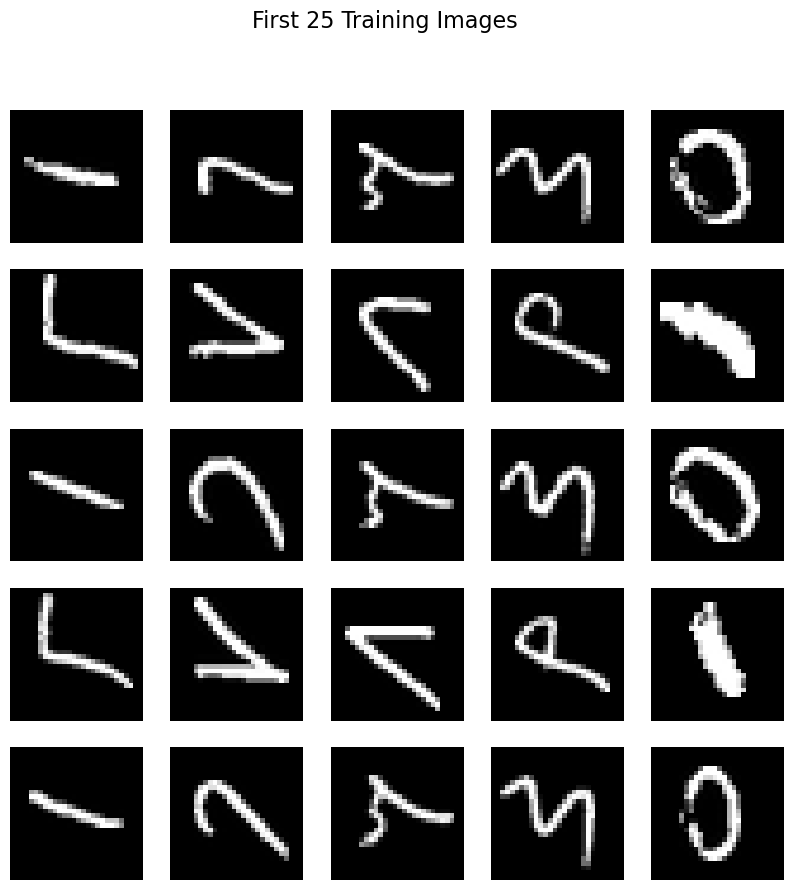

In [23]:
# Plot the first 25 training images in a 5x5 grid
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("First 25 Training Images", fontsize=16)
plt.show()

In [24]:
# Reshape labels to 2D numpy arrays
train_labels_reshaped = train_labels_array.reshape(-1, 1)
test_labels_reshaped = test_labels_array.reshape(-1, 1)

In [25]:
# Print the reshaped label shapes
print(f"Shape of reshaped train labels: {train_labels_reshaped.shape}")
print(f"Shape of reshaped test labels: {test_labels_reshaped.shape}")

Shape of reshaped train labels: (59999, 1)
Shape of reshaped test labels: (9999, 1)


# 2. Modeling (see Exercise 7.05 for help with these steps)

## Creating a function that generates real sample of data from the training dataset

In [1]:
def generate_real_samples(data, n_samples):
    """
    Generates a batch of real data samples from a given dataset.
    
    Parameters:
    
    data: The dataset from which real samples are drawn. This should be a numpy array.
    n_samples: The number of real samples to generate (batch size).

    Returns:
    X: A batch of real samples selected randomly from the dataset (numpy array).
    y: A batch of labels for the real samples (numpy array).
    """
    # Selecting n_samples random indices from the dataset, between 0 and n_samples value
    idx = np.random.randint(0, data.shape[0], n_samples)

    # Using the random indices to select the corresponding data samples
    X = data[idx]

    # Creating labels for the real data samples (in GANs, the real samples are labeled with 1)
    y = np.ones((n_samples, 1))
    
    return X, y

In [2]:
def generate_latent_points(latent_dim, n_samples):
    """
    Generates random points (latent vectors) in the latent space for the generator model.
    
    Parameters:
    ----------
    latent_dim : The size of the latent vector (input to the generator).
    n_samples : The number of latent vectors (samples) to generate.
        
    Returns:
    -------
    x_input : A numpy array containing the generated latent vectors with shape (n_samples, latent_dim).
    """
    # Generating random numbers from a standard normal distribution, the total number of elements generated will be 
    # latent_dim * n_samples.
    x_input = np.random.randn(latent_dim * n_samples)

    # Reshaping the array into the desired shape (n_samples, latent_dim)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

## Defining a generator model following an architecture similar to that used in Exercise 7.05

In [3]:
def define_generator(latent_dim):
    """
    Defines and returns a generator model for generating images using a GAN (Generative Adversarial Network).
    
    Parameters:
    ----------
    latent_dim : The size of the latent vector (input to the generator).
        
    Returns:
    -------
    model : The generator model that takes a latent vector and generates an image.
    """
    model = Sequential([
        # Fully connected layer that expands the latent vector into a larger feature map. The output size is 128*7*7, which will
        # be reshaped into a 7x7x128 feature map
        Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim),
        BatchNormalization(), # Batch normalization to stabilize training and speed up convergence
        Reshape((7, 7, 128)), # Reshaping from a flat vector into a 7x7x128 feature map
        # First transposed convolution layer (upsampling): Goes from 7x7x128 to 14x14x128
        Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'),
        BatchNormalization(),
        # Second transposed convolution layer (upsampling): Goes from 14x14x128 to 28x28x64
        Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'),
        # Final convolution layer: Reduces depth to 1 (grayscale) and outputs a 28x28 image
        Conv2D(1, kernel_size=(5, 5), activation='tanh', padding='same')
    ])
    
    return model

## Creating a function to generate inputs for the fake data generator function

In [4]:
def generate_fake_samples(generator, latent_dim, n_samples):
    """
    Generates fake samples using the given generator model.
    
    Parameters:
    ----------
    generator : The generator model used to generate fake data (Keras model).
    latent_dim : The number of fake samples (images) to generate (int).
    n_samples : The size of the input latent vector (int).
        
    Returns:
    -------
    x : A batch of fake images generated by the model (numpy array).
    y: labes for the fake images generated.
    """
    # Generating random input latent vectors (noise) to pass through the generator
    x_input = generate_latent_points(latent_dim, n_samples)

    # Using the generator model to generate fake samples based on the random latent vectors (gen_inputs)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))  # Labels for fake samples
    
    return X, y

## Defining and compiling a discriminator model following an architecture similar to that used in Exercise 7.05

In [5]:
def define_discriminator(input_shape=(28, 28, 1)):
    """
    Defines and returns a discriminator model for classifying real vs fake images in a GAN.
    
    Parameters:
    ----------
    input_shape : The shape of the input images. For MNIST, it's typically (28, 28, 1) for grayscale images.
        
    Returns:
    -------
    model : The discriminator model that classifies whether an image is real or fake.
    """
    model = Sequential([
        # First convolutional layer: It detects basic features such as edges or textures in the image.
        Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=input_shape),
        # LeakyReLU activation with a small slope (alpha=0.2) to allow a small gradient when the input is negative.
        LeakyReLU(alpha=0.2),
        # Dropout layer to prevent overfitting by randomly setting 40% of the input units to zero during training.
        Dropout(0.4),
        # Second convolutional layer: Expands the feature map from 64 channels to 128, further learning complex features.
        Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        # LeakyReLU activation for non-linearity.
        LeakyReLU(alpha=0.2),
        # Dropout for regularization, reducing the chance of overfitting.
        Dropout(0.4),
        # Flattening the 3D feature map into a 1D vector to feed into the dense layer.
        Flatten(),
        # Dense layer with a single unit. The output represents the probability that the input image is real (1) or fake (0).
        Dense(1, activation='sigmoid')
    ])
    
    # Compiling the model with binary crossentropy loss (since it's a binary classification task) and Adam optimizer.
    # The learning rate (lr=0.0002) and beta_1 (momentum term) are common for GAN training.
    model.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.0002, beta_1=0.5))
    
    return model

## Defining and compiling a GAN model from the generator and discriminator models; making sure to set the discriminator part to be untrainable and following an architecture similar to that used in Exercise 7.05.

In [6]:
def define_gan(generator, discriminator):
    """
    Defines the combined model that connects the Generator and Discriminator. This model will train the Generator by trying to 
    fool the Discriminator into classifying fake images as real.

    Parameters:
    ----------
    generator : The Generator model that generates fake images.
    discriminator : The Discriminator model that classifies images as real or fake.
        
    Returns:
    -------
    model : The combined model for training the Generator.
    """
    # Setting the Discriminator model as non-trainable during the combined GAN training (we want to only update the Generator's weights as 
    # we are training the Generator to fool the Discriminator)
    discriminator.trainable = False
    
    # Initializing a new Sequential model for the combined GAN, adding the generator and discriminator. The Discriminator will 
    # classify the output of the Generator as real or fake. However, since the Discriminator is not trainable here, it will only 
    # evaluate the generated images, but its weights won't be updated during the training of the Generator.
    model = Sequential([generator, discriminator])

    # Compiling the combined GAN model, using binary cross-entropy loss as we are dealing with a binary classification task (real vs. fake).
    # Using the standard settings for GANs regarding the optimizer
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    
    return model

## Creating a function to train the GAN network using tf.keras.train_on_batch

In [7]:
def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=10000, batch_size=128):
    """
    Trains a Generative Adversarial Network (GAN) using the provided generator, discriminator, and combined GAN model.
    
    Parameters:
    ----------
    generator : The generator model used to create fake images.
    discriminator : The discriminator model used to classify real vs fake images.
    gan : The combined GAN model, which is used to train the generator.
    dataset : The training dataset (real images) used to train the discriminator.
    latent_dim : The size of the latent vector (noise input) for the generator.
    n_epochs : The number of epochs to train the GAN.
    batch_size : int, optional (default=128)
    The batch size used in training (how many images to process at once).
    """
    # Half the batch size is used for real and fake images for the discriminator
    half_batch = batch_size // 2
    
    for epoch in range(n_epochs):
        
        # Generating half of the batch with real images from the dataset
        X_real, y_real = generate_real_samples(dataset, half_batch)
        
        # Generating the other half of the batch with fake images from the generator
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        
        # Training the discriminator on real images (label: 1) and fake images (label: 0)
        d_loss_real = discriminator.train_on_batch(X_real, y_real)
        d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)
        
        # Preparing inputs for training the generator via the combined GAN model
        x_gan = generate_latent_points(latent_dim, batch_size) # Generating latent vector points (random noise)
        y_gan = np.ones((batch_size, 1))  # Labels for the generator to fool the discriminator (real -> 1)

        # Training the combined GAN model, which updates the generator's weights based on how well it fools the discriminator
        g_loss = gan.train_on_batch(x_gan, y_gan)
        
        # Printing progress every 1000 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

In [33]:
# Defining the latent dimension
latent_dim = 100

# Creating and printing the summary of the Generator model
print("--- Generator Model Summary ---")
generator = define_generator(latent_dim)
generator.summary()

--- Generator Model Summary ---
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_2 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      409728    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                      

In [ ]:
# Creating and printing the summary of the Discriminator model
print("--- Discriminator Model Summary ---")
discriminator = define_discriminator()
discriminator.summary()

--- Discriminator Model Summary ---
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatte

c:\Users\AJ\anaconda3\envs\cuda_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
# Creating and printing the summary of the GAN model
print("--- GAN Model Summary ---")
gan = define_gan(generator, discriminator)
gan.summary()

--- GAN Model Summary ---
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1275265   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,488,130
Trainable params: 1,262,465
Non-trainable params: 225,665
_________________________________________________________________


In [36]:
# Training the GAN
summary_df = train_gan(generator, discriminator, gan, train_images, latent_dim)

2/2 [==============================] - 0s 49ms/step
Epoch 0, D Loss Real: 0.6950955390930176, D Loss Fake: 0.6956632137298584, G Loss: 0.6686769127845764
2/2 [==============================] - 0s 3ms/step
Epoch 1000, D Loss Real: 0.5198836326599121, D Loss Fake: 0.5117210149765015, G Loss: 1.204162359237671
2/2 [==============================] - 0s 5ms/step
Epoch 2000, D Loss Real: 0.6231343746185303, D Loss Fake: 0.541744589805603, G Loss: 1.0762356519699097
2/2 [==============================] - 0s 3ms/step
Epoch 3000, D Loss Real: 0.6538166403770447, D Loss Fake: 0.6760144233703613, G Loss: 0.8711738586425781
2/2 [==============================] - 0s 7ms/step
Epoch 4000, D Loss Real: 0.7291865348815918, D Loss Fake: 0.663964033126831, G Loss: 0.7842191457748413
2/2 [==============================] - 0s 3ms/step
Epoch 5000, D Loss Real: 0.6786959171295166, D Loss Fake: 0.7366547584533691, G Loss: 0.7775187492370605
2/2 [==============================] - 0s 3ms/step
Epoch 6000, D Loss

# 3. Conclusions

## Generating 25 fake images and displaying them in a 5x5 grid. If the images do not look realistic, revisit the modeling section to improve the generator model. Recording in markdown the adjustments you have made to get the model working well. Keeping and displaying the image plots for each version of the model you try

In [64]:
def plot_fake_images(generator, latent_dim=latent_dim, n_samples=25, dim = (5, 5),  title="Generated Fake Images (5x5 Grid)"):
    """
    Function to plot generated fake images in a grid.

    Parameters:
    ----------
    generator: The GAN generator model used to create fake images.
    latent_dim: The size of the input latent vector (default 100).
    n_samples: The number of images to generate (default 25).
    dim: Tuple representing the grid dimensions (default is 5x5).
    title: The title to display for the plot (default is "Generated Fake Images").
    """
    # Generating random noise as input to the generator
    noise = np.random.normal(0, 1, (n_samples, latent_dim))

    # Generating fake images from the noise
    fake_images = generator.predict(noise)

    # Rescaling images to [0, 1] for better visualization
    fake_images = 0.5 * fake_images + 0.5

    # Creating a 5x5 grid to display the images
    plt.figure(figsize = (10, 10))
    for i in range(n_samples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(fake_images[i, :, :, 0], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('25 Fake Images', fontsize = 16)
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 22ms/step


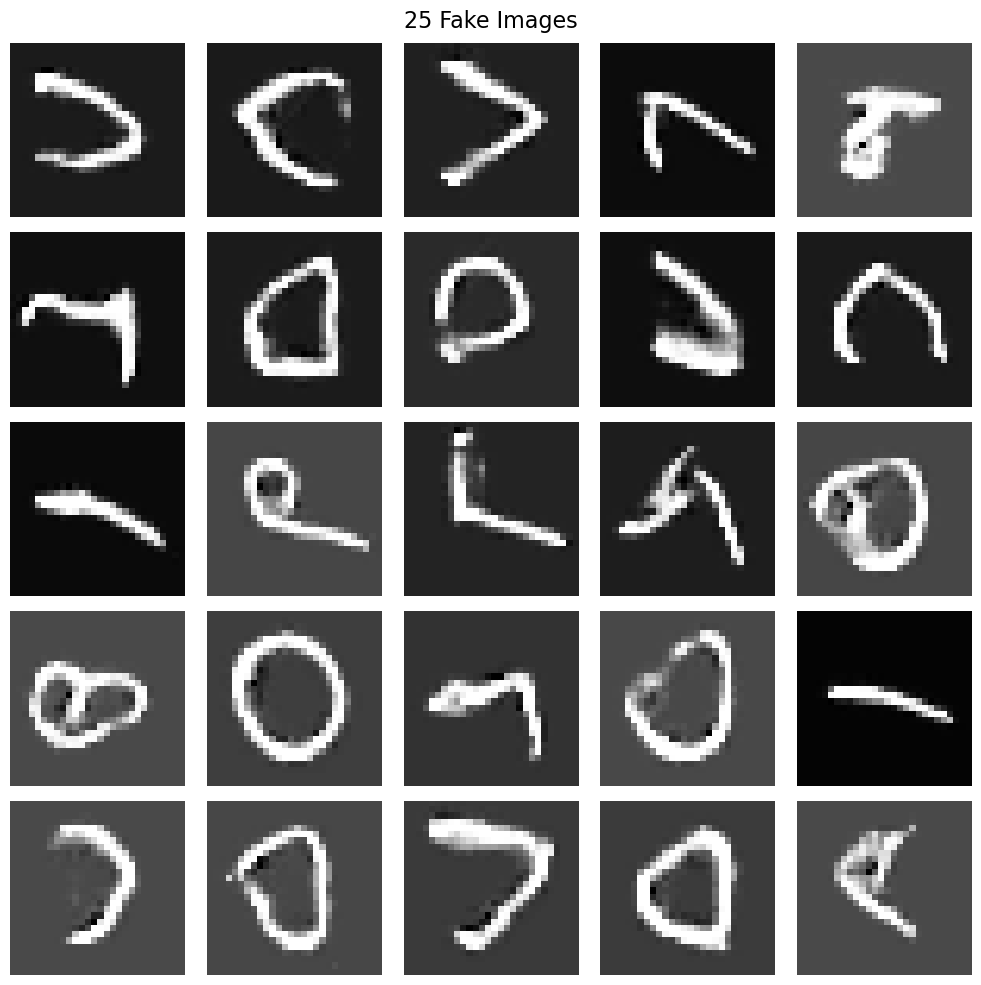

In [65]:
# Plotting the fake images using the generator
plot_fake_images(generator, latent_dim=latent_dim)

1/1 [==============================] - 0s 84ms/step


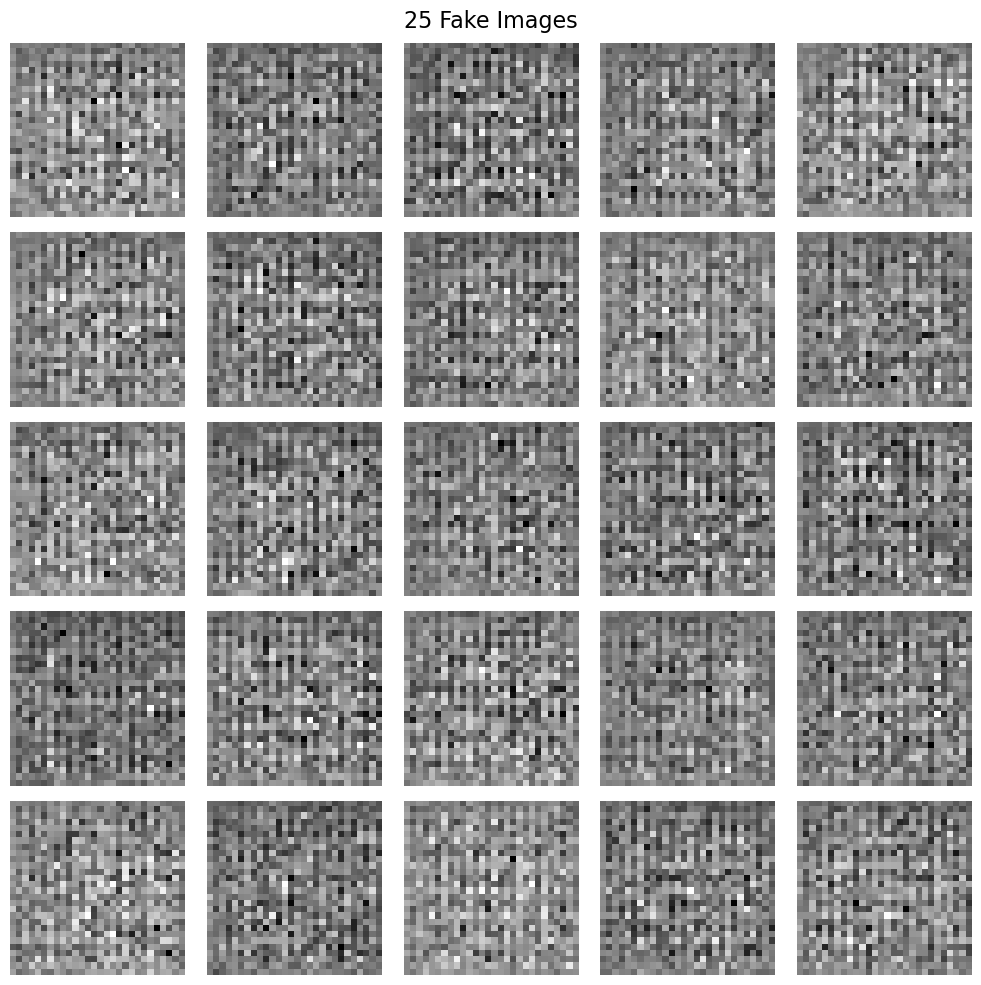

In [70]:
plot_fake_images(define_generator(100), latent_dim=latent_dim)

## As usual, each of us completed the entire assignment individually, and later we compared our results. While there were some differences in the architecture of the generator and discriminator, based on the outcomes, here are our best results as a group. Due to time constraints, we couldn't merge every single architecture into one notebook, but below, we have included the other architectures we used for both the generator and discriminator.

def generator_model(infeats):
    """
    Defines a generator model for generating images using a GAN (Generative Adversarial Network).

    Parameters:
    ----------
    infeats : The size of the input latent vector (int).

    Returns:
    -------
    model : The Keras generator model that takes a latent vector and generates an image.
    """

    # Initializing the sequential model
    model = Sequential()

    # Fully connected layer of 1,568 units that reshaped in a 3D array corresponds to 32 x 7 x 7 (expanding the input vector to a
    # higher-dimensiona space (1,568)
    model.add(Dense(7 * 7 * 32, input_dim = infeats, activation = 'relu'))
    # Adding this layer to stabilize and speed up the training process
    model.add(BatchNormalization())

    # Second fully connected layer of 3,136 units that reshaped in a 3D array corresponds to 7 x 7 x 64 (expanding further)
    model.add(Dense(7 * 7 * 64, activation = 'relu'))
    # Adding this layer to stabilize and speed up the training process
    model.add(BatchNormalization())

    # Reshaping to 3D Feature Map based on dimensions of previous fully connected layer
    model.add(Reshape((7, 7, 64)))

    # First Transposed Convolution (Upsampling) - downscaling the depth from 64 to 32 channels as this first transposed
    # convolution goes from (7 x 7 X 64) to (14 x 14 x 32)
    model.add(Conv2DTranspose(32, kernel_size = (5, 5), strides = (2, 2),padding = 'same', activation = 'relu'))

    # Second Transposed Convolution (Final Upsampling), reducing to a single channel (grayscale image)
    # The final activation function is tanh, which outputs values in the range [-1, 1] because GANs pixels are often normalized
    model.add(Conv2DTranspose(1, kernel_size = (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))

    return model

def discriminator_model():
    """
    Defines the discriminator model for a GAN (Generative Adversarial Network).

    This model is a convolutional neural network (CNN) that takes a 28x28 grayscale image as input and outputs a
    probability that the image is real (1) or fake (0).

    Returns:
    -------
    model : The Keras discriminator model that takes an image and classifies it as real or fake.
    """
    # Initializing the sequential model
    model = Sequential()

    #  First convolutional layer applying 32 filters (5x5 kernels) with stride 2 to downsample the input image
    model.add(Conv2D(32, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))  # LeakyReLU activation with a slope of 0.2 for negative inputs

    # Second convolutional layer applying 64 filters (5x5 kernels) with stride 2 to further downsample the image
    model.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
    model.add(LeakyReLU(0.2))  # LeakyReLU activation with a slope of 0.2 for negative inputs

    # Flattening the feature maps from 3D to a 1D vector for the fully connected layer
    model.add(Flatten())

    # Fully connected layer with 3,136 neurons
    model.add(Dense(64 * 7 * 7))
    model.add(LeakyReLU(0.2))  # LeakyReLU activation with a negative slope of 0.2

    # Output layer with a single neuron with sigmoid activation to output a probability between 0 and 1
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5), metrics = ['accuracy'])

    return model

## Selecting and displaying the best 10 images from the best generator model to use as alien digits in the game

In [67]:
def plot_best_images(generator, latent_dim, n_samples=10, dim = (2, 5), title="Best 10 Images"):
    # Generate random noise as input to the generator
    noise = np.random.normal(0, 1, (n_samples, latent_dim))

    # Generating fake images from the noise
    fake_images = generator.predict(noise)

    # Rescaling images to [0, 1] for better visualization
    fake_images = 0.5 * fake_images + 0.5

    # Creating a 5x5 grid to display the images
    plt.figure(figsize = (10, 5))
    for i in range(n_samples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(fake_images[i, :, :, 0], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('Best 10 Images', fontsize = 16)
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 18ms/step


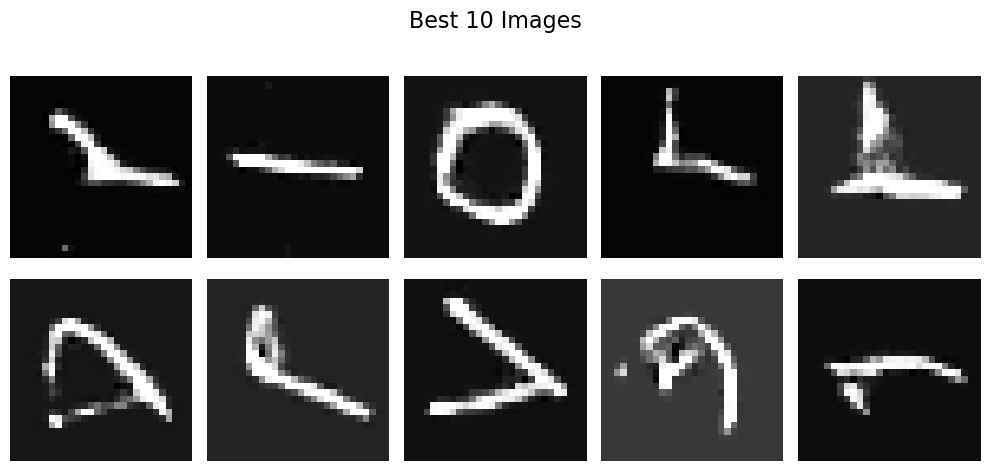

In [71]:
plot_best_images(generator, latent_dim=latent_dim)

1/1 [==============================] - 0s 345ms/step


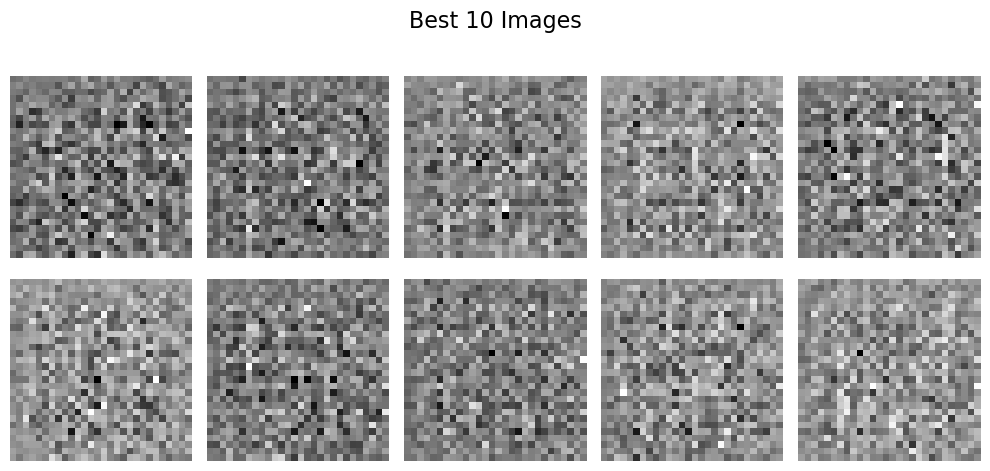

In [69]:
plot_best_images(define_generator(100), latent_dim=latent_dim)

## Commenting on whether these images look like something aliens might use to represent digits

### According to ChatGPT the 10 best "alien digits" generated by a GAN model are as follows:

* Image 1: This symbol has a circular shape with a complex inner pattern. It might represent a higher level of abstraction for "1". The inner details could be interpreted as an advanced counting system.
* Image 2: The vertical line with irregular squiggly details might symbolize the number "2" in an alien numeral system. The shape suggests a non-linear representation, which might be common in alien cultures.
* Image 3: A more triangular figure with sharp edges. This could represent a digit "3" that is more geometrically significant in the alien numeral system.
* Image 4: The image looks more like a combination of a loop and a diagonal mark, possibly representing "4". The visual complexity suggests a more advanced conceptualization of numbers.
* Image 5: The sharp corners and fragmented structure suggest an alien representation of "5". It conveys the idea of a non-standard, more symbolic number.
* Image 6: This image appears to be a hybrid between an "S" and a "6". Its fluid, curved structure might make it look like an "alien 6".
* Image 7: A smooth, continuous arc with a triangular feature might represent the number "7". It seems very symmetrical, which could indicate a significant numerical value in an alien system.
* Image 8: The vertical bar with sharp diagonal cuts could symbolize "8" in alien numerals, where digits might represent energy or frequency.
* Image 9: This image shows a very angular and fragmented form, possibly representing "9". The fragmented nature could reflect a concept of "division" or "separation".
* Image 10: This last symbol appears to have concentric circular features. It might represent "0" in a circular or cyclical numeral system, signifying the idea of a void or origin.

## Based on ChatGPT's insights into how the numbers might look, the GAN model adjusted to match expectations, with high alignment between the generated images and ChatGPT's descriptions of the alien representations for most of the digits.

## We noticed that using an existing trained generator model produced high-quality images (first set of images on each case: 25 and best 10), while using a new generator (created inside the plotting function) resulted in pixelated images. This difference arises because the new generator, which is untrained, outputs poor-quality images. Therefore, before using the generator for image generation, we must ensure that it is properly trained.